# Validation

In [1]:
import os
import glob
import re
import torch
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn
from torchvision import transforms, datasets
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from networks.resnet_big import SupCEResNet, SupConResNet, LinearClassifier, model_dict
from util_logging import add_tsne_to_run_md, add_confusion_matrix_to_run_md, create_val_md
from util_pre_com_feat import featureEmbeddingDataset

seaborn.set_theme(style="darkgrid")

### Parameters

In [17]:
# TODO remove
# def get_val_dataset_params(dataset_val):
#     if dataset_val == "animals10" or dataset_val == "animals10_300x300":
#         # animals10_300x300
#         root_train = "./datasets/animals10_300x300/train/"
#         root_test = "./datasets/animals10_300x300/test/"
#         mean = (0.3837, 0.3704, 0.3072)
#         std = (0.3268, 0.3187, 0.3051)
#     elif dataset_val == "animals10_diff_-1":
#         root_train = "./datasets/animals10_diff/-1/train/"
#         root_test = "./datasets/animals10_diff/-1/test/"
#         mean = (0.3816, 0.3683, 0.3052)
#         std = (0.3281, 0.3198, 0.3055)
#     elif dataset_val == "animals10_diff_4000":
#         root_train = "./datasets/animals10_diff/4000/train/"
#         root_test = "./datasets/animals10_diff/4000/test/"
#         mean = (0.3869, 0.3732, 0.3088)
#         std = (0.3273, 0.3186, 0.3039)
#     else:
#         root_train = None
#         root_test = None
#         mean = None
#         std = None

#     return root_train, root_test, mean, std

# def split_path_model(root_model):
#     path = root_model.split('/')

#     for i in range(len(path)):
#         if re.fullmatch(
#             ".+_.+_lr_[0-9]+(\.[0-9]+)?_decay_[0-9]+\.[0-9]+_bsz_[1-9][0-9]*_temp_[0-9]+(\.[0-9]+)?_trial_[0-9]+(_.+)*",
#             path[i]) != None:
#             break
#         elif re.fullmatch(
#             ".+_.+_lr_[0-9]+(\.[0-9]+)?_decay_[0-9]+\.[0-9]+_bsz_[1-9][0-9]*_trial_[0-9]+(_.+)*",
#             path[i]) != None:
#             break

#     # check if checkpoint is in folder with correct name to determent params
#     assert i < len(path)-1

#     return path, i

# def get_params(root_model, dataset_val):
#     path, i = split_path_model(root_model=root_model)

#     params = dict()

#     model_folder = path[i]
#     params['dataset'] = path[i-1]
#     folder_split = model_folder.replace(params['dataset'], '<dataset>').split('_')
#     params['method'] = folder_split[0]
#     params['model_name'] = folder_split[2]

#     flag_pos = 11 if params['method'] == "SupCE" else 13
#     for j in range(3,flag_pos,2):
#         params[folder_split[j]] = int(folder_split[j+1]) if (folder_split[j] in ['bsz', 'trial']) else float(folder_split[j+1])

#     for f in folder_split[flag_pos:]:
#         params[f] = True

#     epoch = path[-1].replace(".pth", '').split('_')[-1]

#     if dataset_val == params['dataset']:
#         path_run_md = os.path.join(*path[:i+1])
#         path_embeddings = os.path.join(path_run_md, f"val_{epoch}", "embeddings")
#     else:
#         path_run_md = os.path.join(*path[:i+1], f"val_{dataset_val}.md")
#         path_embeddings = os.path.join(*path[:i+1], f"val_{dataset_val}_{epoch}", "embeddings")

#     return params, epoch, path_run_md, path_embeddings

# def get_path_classifier(root_model, dataset_val, params, epoch):
#     path, i = split_path_model(root_model=root_model)
#     if dataset_val == params['dataset']:
#         path_classifier = glob.glob(os.path.join(*path[:i+1], f"val_{epoch}", "classifier", "*/"))
#     else:
#         path_classifier = glob.glob(os.path.join(*path[:i+1], f"val_{dataset_val}_{epoch}", "classifier", "*/"))
#     if len(path_classifier) > 0:
#         path_classifier = (path_classifier[0])[:-1]

#     return path_classifier

# def get_path_comb_md(root_model, dataset_val, dataset_second):
#     path, i = split_path_model(root_model=root_model)
#     if dataset_val < dataset_second:
#         path_comb_md = os.path.join(*path[:i+1], f"comb_{dataset_val}_{dataset_second}.md")
#         path_comb = os.path.join(*path[:i+1], f"comb_{dataset_val}_{dataset_second}")
#     else:
#         path_comb_md = os.path.join(*path[:i+1], f"comb_{dataset_second}_{dataset_val}.md")
#         path_comb = os.path.join(*path[:i+1], f"comb_{dataset_second}_{dataset_val}")

#     path_save = os.path.join(*path[:i+1])

#     return path_comb_md, path_comb, path_save

In [18]:
# TODO remove
# cuda_device = 0
# tsenecuda_venv = "/home/tgottwald/tsnecuda_venv/"


# # model checkpoint to validate
# # root_model = "./save/SupCE/animals10/SupCE_animals10_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_baseline_cosine/models/ckpt_epoch_500.pth"
# # root_model = "./save/SupCE/untrained/SupCE_untrained_resnet18_lr_0.0_decay_0.0001_bsz_26_trial_0_noTraining/models/last.pth"
# # root_model = "./save/SupCE/animals10_diff_4000/SupCE_animals10_diff_4000_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_4000_cosine/models/last.pth"

# # root_model = "./save/SupCon/animals10/SupCon_animals10_resnet18_lr_0.5_decay_0.0001_bsz_26_temp_0.1_trial_0_try2_cosine/models/last.pth"
# root_model = "./save/SupCon/animals10_diff_-1+4000/SupConHybrid_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_noAug_cosine/models/last.pth"


# # the name of the dataset to validate on
# # dataset_val = "animals10_diff_-1"
# dataset_val = "animals10_diff_4000"
# # dataset_val = "animals10"


# tsenecuda_venv_lib64 = os.path.join(tsenecuda_venv, "lib64")
# tsenecuda_venv_interpreter = os.path.join(tsenecuda_venv, "bin/python")

# root_train, root_test, mean, std = get_val_dataset_params(dataset_val=dataset_val)
# params, epoch, path_run_md, path_embeddings = get_params(root_model, dataset_val)

# # change loading of mean and std (needed to be consistent with mean and std)
# if params['dataset'] == "animals10_diff_-1" or params['dataset'] == "animals10_diff_-1+4000":
#     mean = (0.3816, 0.3683, 0.3052)
#     std = (0.3281, 0.3198, 0.3055)
# elif params['dataset'] == "animals10_diff_4000":
#     mean = (0.3869, 0.3732, 0.3088)
#     std = (0.3273, 0.3186, 0.3039)

In [2]:
def get_root_dataset_test(dataset):
    if dataset == "animals10" or dataset == "animals10_300x300":
        # animals10_300x300
        root_train = "./datasets/animals10_300x300/train/"
        root_test = "./datasets/animals10_300x300/test/"
    elif dataset == "animals10_diff_-1":
        root_train = "./datasets/animals10_diff/-1/train/"
        root_test = "./datasets/animals10_diff/-1/test/"
    elif dataset == "animals10_diff_4000":
        root_train = "./datasets/animals10_diff/4000/train/"
        root_test = "./datasets/animals10_diff/4000/test/"
    else:
        root_test = None

    return root_train, root_test

def get_paths_to_embeddings_and_run_md(root_model, dataset):
    split_model = root_model.split('/')

    epoch = split_model[-1].replace(".pth", '').split('_')[-1]

    training_dataset = split_model[-4]

    if dataset == training_dataset:
        path_run_md = os.path.join(*split_model[:-2])
        path_embeddings = os.path.join(*split_model[:-2], f"val_{epoch}", "embeddings")
    else:
        path_run_md = os.path.join(*split_model[:-2], f"val_{dataset}.md")
        path_embeddings = os.path.join(*split_model[:-2], f"val_{dataset}_{epoch}", "embeddings")

    return path_run_md, path_embeddings, epoch

def try_eval(val):
    try:
        return eval(val)
    except:
        return val
    
def read_parameters_from_run_md(root_model):
    split_model = root_model.split('/')
    with open(os.path.join(*split_model[:-2], "run.md"), 'r') as f:
        lines = f.readlines()

    params = dict()

    line_indices = [7, 13, 19]
    for idx in line_indices:
        params_names = lines[idx].split(' | ')
        params_names[0] = params_names[0].replace('| ', '')
        params_names[-1] = params_names[-1].replace(' |\n', '')
        params_names = [name.replace(' ', '_') for name in params_names]

        params_vals = lines[idx+2].split('|')[1:-1]
        params_vals = [try_eval(val) for val in params_vals]

        for i,n in enumerate(params_names):
            params[n] = params_vals[i]

    return params

def get_path_classifier(root_model, dataset, params, epoch):
    split_model = root_model.split('/')
    if dataset == params['dataset']:
        path_classifier = glob.glob(os.path.join(*split_model[:-2], f"val_{epoch}", "classifier", "*/"))
    else:
        path_classifier = glob.glob(os.path.join(*split_model[:-2], f"val_{dataset}_{epoch}", "classifier", "*/"))
    if len(path_classifier) > 0:
        path_classifier = (path_classifier[0])[:-1]

    return path_classifier

def get_path_comb_md(root_model, dataset_1, dataset_2):
    split_model = root_model.split('/')
    if dataset_1 < dataset_2:
        path_comb_md = os.path.join(*split_model[:-2], f"comb_{dataset_1}_{dataset_2}.md")
        path_comb = os.path.join(*split_model[:-2], f"comb_{dataset_1}_{dataset_2}")
    else:
        path_comb_md = os.path.join(*split_model[:-2], f"comb_{dataset_2}_{dataset_1}.md")
        path_comb = os.path.join(*split_model[:-2], f"comb_{dataset_2}_{dataset_1}")

    path_save = os.path.join(*split_model[:-2])

    return path_comb_md, path_comb, path_save

In [5]:
cuda_device = 0
tsenecuda_venv = "/home/tgottwald/tsnecuda_venv/"

root_model = "./save/SupCon/animals10_diff_-1+4000/SupConHybrid_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_noAug_cosine/models/last.pth"

dataset_val = "animals10_diff_4000"


tsenecuda_venv_lib64 = os.path.join(tsenecuda_venv, "lib64")
tsenecuda_venv_interpreter = os.path.join(tsenecuda_venv, "bin/python")

root_train, root_test = get_root_dataset_test(dataset_val)

path_run_md, path_embeddings, epoch = get_paths_to_embeddings_and_run_md(root_model, dataset_val)

params = read_parameters_from_run_md(root_model)
mean = params['mean']
std = params['std']
params['model_name'] = params['model']
params['bsz'] = params['batch_size']

### Dataloader and Model

In [6]:
if dataset_val == 'cifar10':
    root_train = "./datasets/"
    root_test = "./datasets/"
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
elif dataset_val == 'cifar100':
    root_train = "./datasets/"
    root_test = "./datasets/"
    mean = (0.5071, 0.4867, 0.4408)
    std = (0.2675, 0.2565, 0.2761)

normalize = transforms.Normalize(mean=mean, std=std)

val_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

if dataset_val == 'cifar10':
    train_dataset = datasets.CIFAR10(root=root_train,
                                     transform=val_transform,
                                     download=True)
    val_dataset = datasets.CIFAR10(root=root_test,
                                   train=False,
                                   transform=val_transform)
elif dataset_val == 'cifar100':
    train_dataset = datasets.CIFAR100(root=root_train,
                                      transform=val_transform,
                                      download=True)
    val_dataset = datasets.CIFAR100(root=root_test,
                                    train=False,
                                    transform=val_transform)
else:
    train_dataset = datasets.ImageFolder(root=root_train,
                                         transform=val_transform)
    val_dataset = datasets.ImageFolder(root=root_test,
                                       transform=val_transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=params['bsz'], shuffle=False,
    num_workers=16, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=params['bsz'], shuffle=False,
    num_workers=8, pin_memory=True)

In [7]:
if params['method'] == "SupCE":
    model = SupCEResNet(name=params['model_name'], num_classes=len(train_dataset.classes))
else:
    model = SupConResNet(name=params['model_name'])

ckpt = torch.load(root_model, map_location='cpu')
state_dict = ckpt['model']

new_state_dict = {}
for k, v in state_dict.items():
    k = k.replace("module.", "")
    new_state_dict[k] = v
state_dict = new_state_dict

model = model.cuda(device=cuda_device)

model.load_state_dict(state_dict)

<All keys matched successfully>

### Compute Embedding

In [8]:
if not os.path.isdir(path_embeddings):
    os.makedirs(path_embeddings)

if params['dataset'] != dataset_val:
    create_val_md(path_val_md=path_run_md, dataset_val=dataset_val)

_, embedding_size = model_dict[params['model_name']]

model.eval()

embedding = np.array([])
class_labels = np.array([], dtype=int)
for idx, (images, labels) in enumerate(tqdm(train_loader)):
    images = images.cuda(device=cuda_device, non_blocking=True)

    with torch.no_grad():
        features = model.encoder(images)

    embedding = np.append(embedding, features.cpu().numpy())
    class_labels = np.append(class_labels, labels.numpy())


embedding = embedding.reshape(-1, embedding_size)

entry = {'data': embedding, 'labels': class_labels}
with open(os.path.join(path_embeddings, "embedding_train"), 'wb') as f:
    pickle.dump(entry, f, protocol=-1)


embedding = np.array([])
class_labels = np.array([], dtype=int)
for idx, (images, labels) in enumerate(tqdm(val_loader)):
    images = images.cuda(device=cuda_device, non_blocking=True)

    with torch.no_grad():
        features = model.encoder(images)

    embedding = np.append(embedding, features.cpu().numpy())
    class_labels = np.append(class_labels, labels.numpy())

embedding = embedding.reshape(-1, embedding_size)

entry = {'data': embedding, 'labels': class_labels}
with open(os.path.join(path_embeddings, "embedding_test"), 'wb') as f:
    pickle.dump(entry, f, protocol=-1)

model = model.cpu()

validation md file already exits: ./save/SupCon/animals10_diff_-1+4000/SupConHybrid_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_noAug_cosine/val_animals10_diff_4000.md


100%|██████████| 202/202 [00:59<00:00,  3.39it/s]


### t-SNE

In [9]:
!CUDA_VISIBLE_DEVICES={cuda_device} LD_LIBRARY_PATH={tsenecuda_venv_lib64} {tsenecuda_venv_interpreter} compute_tsne.py --path {path_embeddings}

Data split train
load feature embedding
compute t-SNE embedding
writ t-SNE embedding
Data split test
load feature embedding
compute t-SNE embedding
writ t-SNE embedding


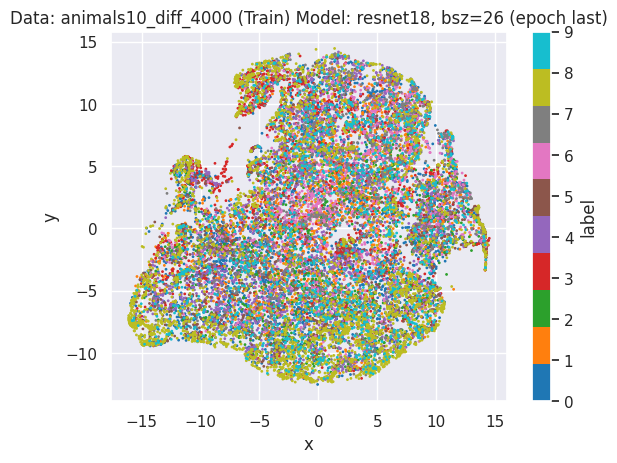

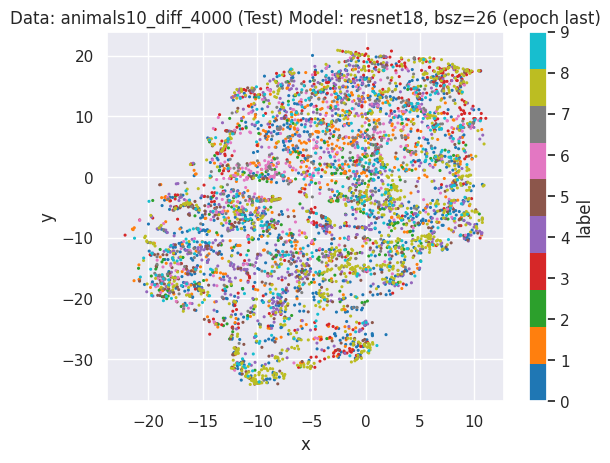

In [10]:
seaborn.set_theme(style="darkgrid")

save_plot = True

with open(os.path.join(path_embeddings, "embedding_tSNE_train"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_tSNE_train = entry['data']
    labels_train = entry['labels']
df_train = pd.DataFrame.from_dict({'x': embedding_tSNE_train[:,0], 'y': embedding_tSNE_train[:,1], 'label': labels_train})

with open(os.path.join(path_embeddings, "embedding_tSNE_test"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_tSNE_test = entry['data']
    labels_test = entry['labels']
df_test = pd.DataFrame.from_dict({'x': embedding_tSNE_test[:,0], 'y': embedding_tSNE_test[:,1], 'label': labels_test})

if save_plot:
    df_train.plot.scatter(x='x', y='y', c='label', colormap='tab10', s=1,
                          title=f"Data: {dataset_val} (Train) Model: {params['model_name']}, bsz={params['bsz']} (epoch {epoch})"
                          ).get_figure().savefig(os.path.join(path_embeddings, f"tSNE_epoch_{epoch}_train.png"))
    df_test.plot.scatter(x='x', y='y', c='label', colormap='tab10', s=1.5,
                         title=f"Data: {dataset_val} (Test) Model: {params['model_name']}, bsz={params['bsz']} (epoch {epoch})"
                         ).get_figure().savefig(os.path.join(path_embeddings, f"tSNE_epoch_{epoch}_test.png"))
    
    add_tsne_to_run_md(path=path_run_md, epoch=epoch, dataset_val=(None if params['dataset']==dataset_val else dataset_val))
else:
    fig, axs = plt.subplots(nrows=2, figsize=(7, 10))
    df_train.plot.scatter(x='x', y='y', c='label', colormap='tab10', s=1, ax=axs[0],
                        title=f"Data: {dataset_val} (Train) Model: {params['model_name']}, bsz={params['bsz']} (epoch {epoch})")
    df_test.plot.scatter(x='x', y='y', c='label', colormap='tab10', s=1.5, ax=axs[1],
                        title=f"Data: {dataset_val} (Test) Model: {params['model_name']}, bsz={params['bsz']} (epoch {epoch})")

### Classifier

In [11]:
classifier_training_call = f"CUDA_VISIBLE_DEVICES={cuda_device} nohup python main_linear.py"\
                          + " --batch_size 256 --batch_size_val 256 --epochs 30 --learning_rate 5"\
                          + f" --model {params['model_name']} --dataset {params['dataset']}"\
                          + f" --data_folder {os.path.join(path_embeddings, 'embedding_train')}"\
                          + f" --test_folder {os.path.join(path_embeddings, 'embedding_test')}"\
                          + " --num_classes 10 --pre_comp_feat"\
                          + f" --tag Epoch{epoch}"\
                          + (f" --md_file val_{dataset_val}.md" if params['dataset'] != dataset_val else "")\
                          + " > precomp_classifier.out"

In [12]:
!{classifier_training_call}

nohup: ignoring input and redirecting stderr to stdout


In [13]:
# move precomp_classifier.out to the classifier directory
path_classifier = get_path_classifier(root_model, dataset_val, params, epoch)

os.makedirs(os.path.join(path_classifier, "out"), exist_ok=True)

os.replace("precomp_classifier.out", os.path.join(path_classifier, "out", "precomp_classifier.out"))

(-0.5, 639.5, 479.5, -0.5)

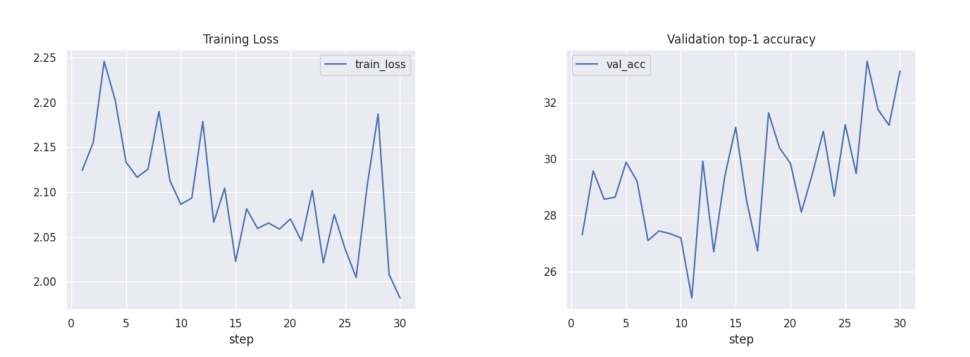

In [14]:
# load plots of classifier Training Loss and Validation Accuracy
train_loss_plot = Image.open(os.path.join(path_classifier, "tensorboard", "train_loss.png"))
val_top1_plot = Image.open(os.path.join(path_classifier, "tensorboard", "val_top1.png"))

fig, axs = plt.subplots(ncols=2, figsize=(10,6))
fig.tight_layout(pad=0)
axs[0].imshow(np.array(train_loss_plot))
axs[0].axis('off')
axs[1].imshow(np.array(val_top1_plot))
axs[1].axis('off')

### Classifier individual Class Accuracies

In [15]:
def set_up_classifier(path_classifier, params, path_embeddings, cuda_device):
    train_dataset = featureEmbeddingDataset(root=os.path.join(path_embeddings, 'embedding_train'))

    val_dataset = featureEmbeddingDataset(root=os.path.join(path_embeddings, 'embedding_test'))

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=256, shuffle=False,
        num_workers=16, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=256, shuffle=False,
        num_workers=16, pin_memory=True)

    classifier = LinearClassifier(name=params['model_name'], num_classes=len(set(val_dataset.targets)))

    ckpt = torch.load(os.path.join(path_classifier, "models", "last.pth"), map_location='cpu')
    state_dict = ckpt['model']

    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    state_dict = new_state_dict

    classifier = classifier.cuda(device=cuda_device)

    classifier.load_state_dict(state_dict)

    return classifier, train_loader, val_loader

def get_predictions(classifier, data_loader, cuda_device):
    classifier.eval()

    true_classes = np.array([], dtype=int)
    pred_classes = np.array([], dtype=int)

    with torch.no_grad():
        for idx, (features, labels) in enumerate(data_loader):
            features = features.float().cuda(device=cuda_device)

            output = classifier(features)
            _, pred = output.topk(1, 1, True, True)

            true_classes = np.append(true_classes, labels.numpy())
            pred_classes = np.append(pred_classes, pred.cpu().numpy().reshape(-1))

    return pd.DataFrame.from_dict({"true_class": true_classes, "pred_class": pred_classes})

def get_confusion_matrix(df_pred):
    # confusion matrix
    C = confusion_matrix(df_pred["true_class"], df_pred["pred_class"])

    c_lens = df_pred.groupby('true_class').count().values.reshape(-1)

    # accuracy
    acc = 0.0
    for i in range(len(c_lens)):
        acc += C[i,i]
    acc *= 100/len(df_pred)
    acc
    # balanced accuracy
    acc_b = 0.0
    for i, n in enumerate(c_lens):
        acc_b += C[i,i] / n
    acc_b *= 100/len(c_lens)
    acc_b

    return C, acc, acc_b

def save_confusion_matrix(C, classes, path, title="Confusion Matrix"):
    disp = ConfusionMatrixDisplay(C, display_labels=classes)
    disp.plot(xticks_rotation=45)
    for labels in disp.text_.ravel():
        labels.set_fontsize(10)
    disp.ax_.set_title(title)
    disp.figure_.tight_layout(pad=0.5)

    plt.savefig(path)

In [16]:
path_classifier = get_path_classifier(root_model, dataset_val, params, epoch)
classifier, train_loader, val_loader = set_up_classifier(path_classifier, params, path_embeddings, cuda_device)

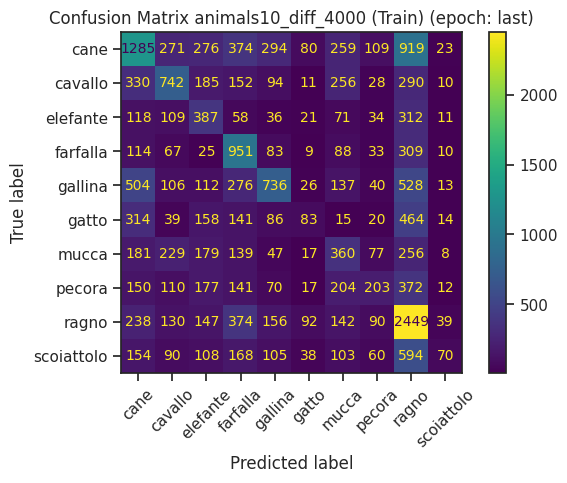

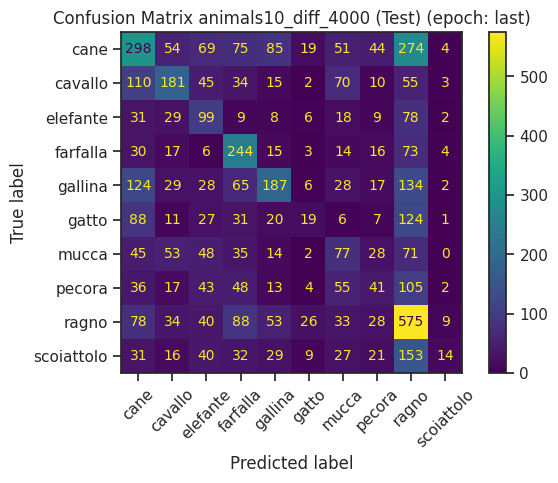

In [17]:
df_pred_train = get_predictions(classifier, train_loader, cuda_device)
df_pred_val = get_predictions(classifier, val_loader, cuda_device)

C_train, acc_train, acc_b_train = get_confusion_matrix(df_pred_train)
C_val, acc_val, acc_b_val = get_confusion_matrix(df_pred_val)

seaborn.set_theme(style="ticks")

classes = [x[:-1].replace(root_test, '') for x in glob.glob(os.path.join(root_test, "*/"))]

save_confusion_matrix(C_train, classes, title=f"Confusion Matrix {dataset_val} (Train) (epoch: {epoch})",
                      path=os.path.join(path_classifier, "models", f"cm_train_epoch_{epoch}.png"))
save_confusion_matrix(C_val, classes, title=f"Confusion Matrix {dataset_val} (Test) (epoch: {epoch})",
                      path=os.path.join(path_classifier, "models", f"cm_val_epoch_{epoch}.png"))

In [18]:
add_confusion_matrix_to_run_md(path_class=path_classifier, acc=acc_val, acc_b=acc_b_val, train_acc=acc_train, train_acc_b=acc_b_train, md_file=(f"val_{dataset_val}.md" if params['dataset']!=dataset_val else None))

### Combine Two Dataset Results

In [6]:
dataset_second = "animals10_diff_-1"

# path to the comb.md file (not jet created)
path_comb_md, path_comb, path_save = get_path_comb_md(root_model, dataset_val, dataset_second)

# path to the embeddings computed using the dateset_second
folder_epoch = f"val_{epoch}" if params['dataset']==dataset_val else f"val_{dataset_val}_{epoch}"
folder_epoch_second = f"val_{epoch}" if params['dataset']==dataset_second else f"val_{dataset_second}_{epoch}"
path_embeddings_second = path_embeddings.replace(folder_epoch, folder_epoch_second)

# path to the classifiers trained on the embeddings of dataset_val and dateset_second
path_classifier = get_path_classifier(root_model, dataset_val, params, epoch)
path_classifier_second = get_path_classifier(root_model, dataset_second, params, epoch)

# get all existing validation folders
all_val_folders = [folder_path.split('/')[-1] for folder_path in glob.glob(os.path.join(path_save, f"val_*[!.md]"))]

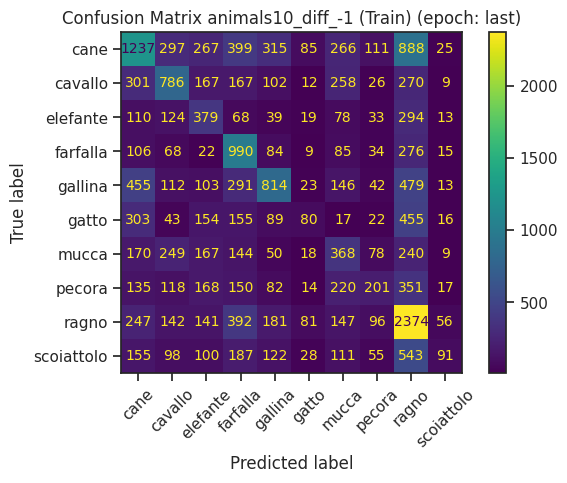

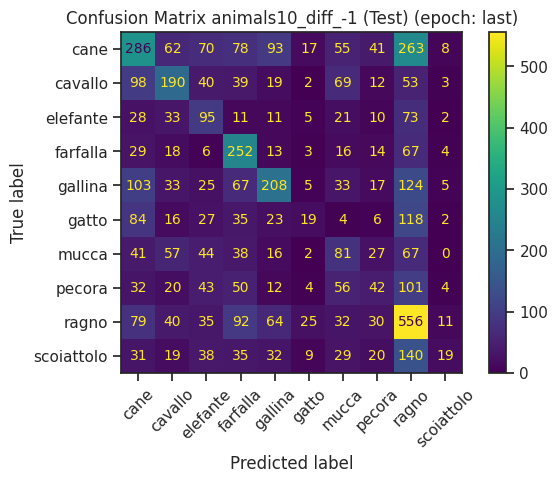

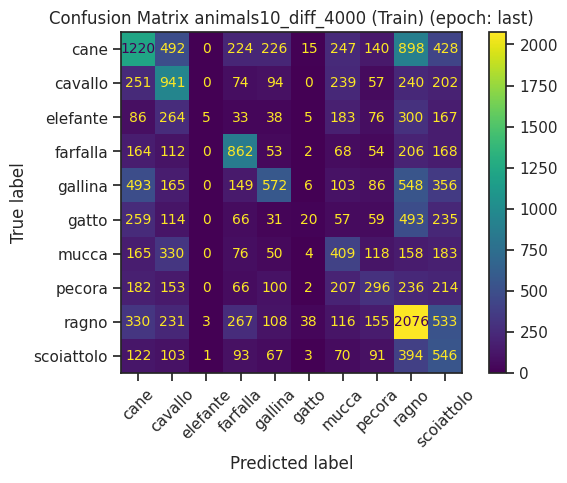

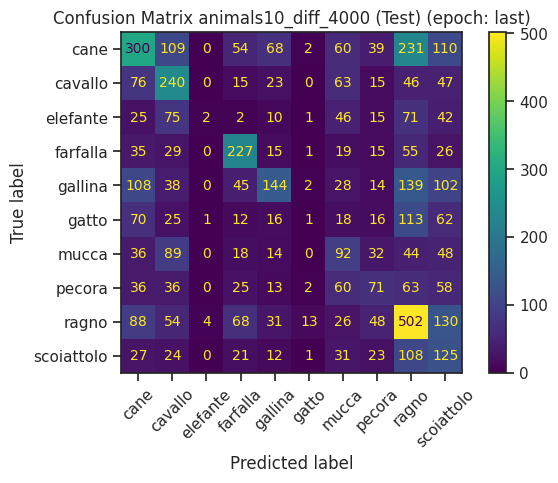

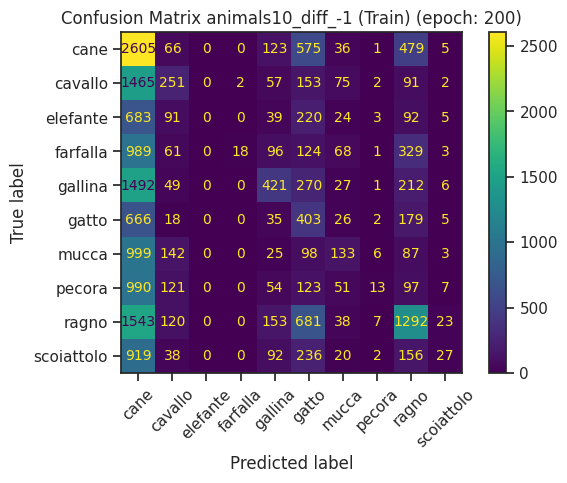

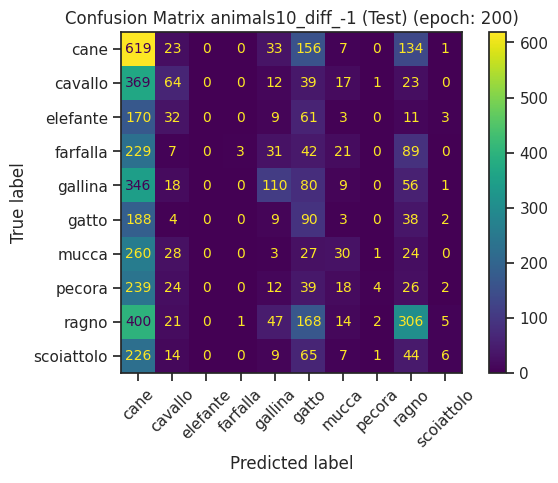

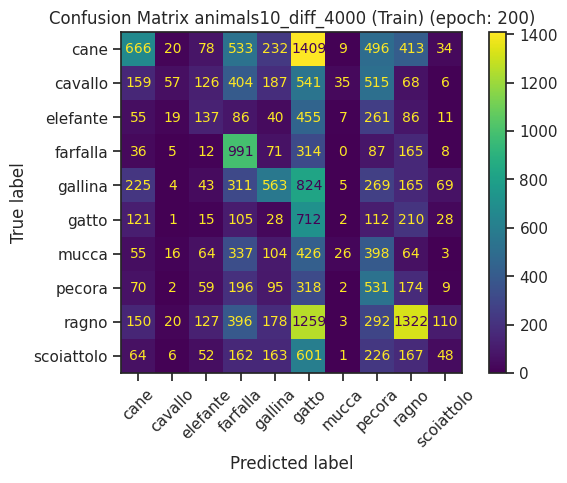

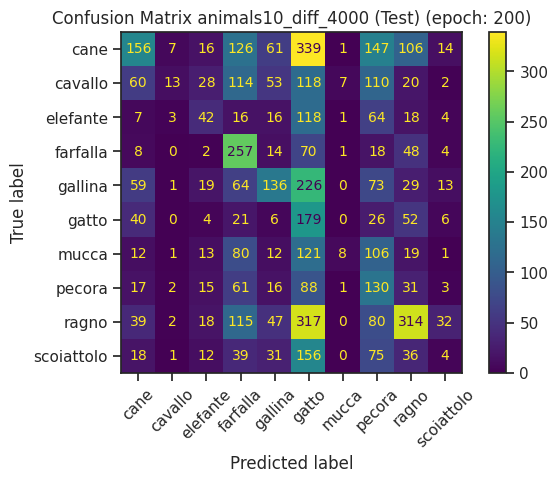

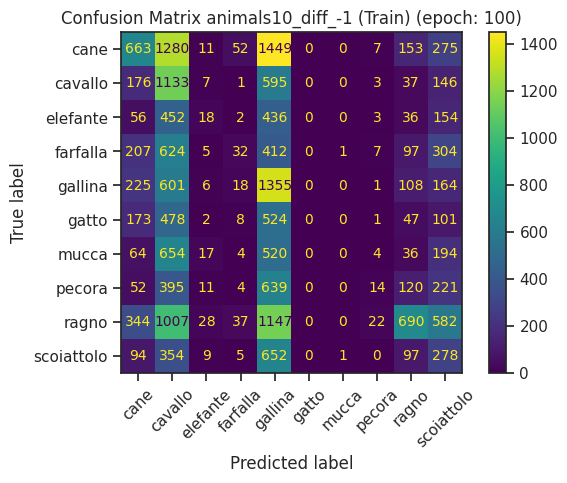

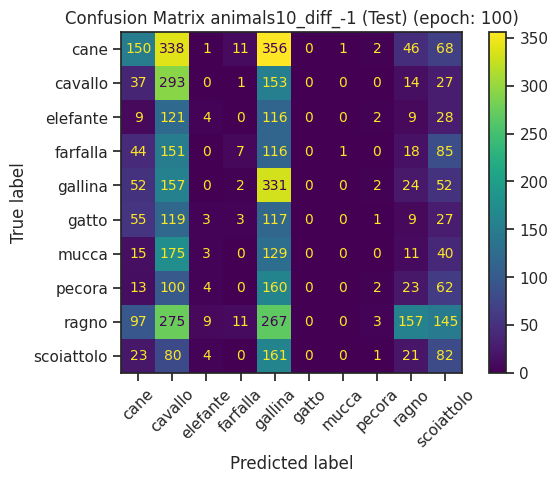

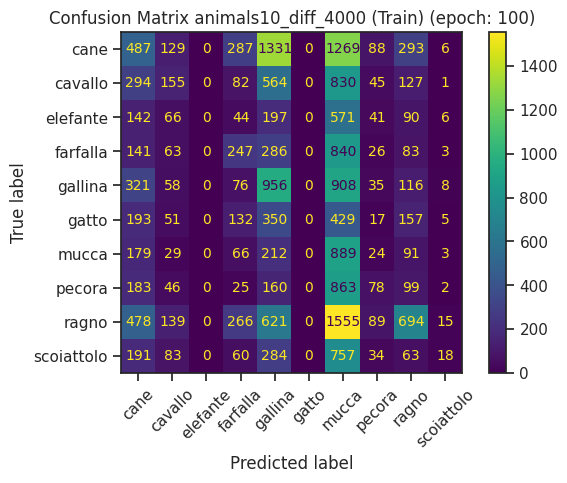

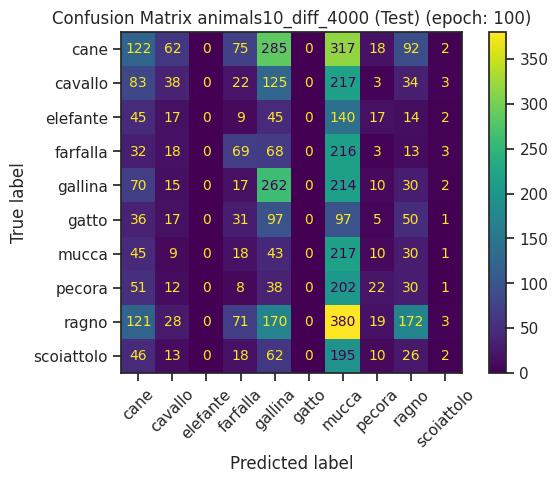

In [21]:
all_epochs = set([val_folder.split('_')[-1] for val_folder in all_val_folders])

comb_plots = dict()
for e in all_epochs:
    # check that this epoch checkpoint was evaluated on both datasets
    folder_e = f"val_{e}" if params['dataset']==dataset_val else f"val_{dataset_val}_{e}"
    folder_e_second = f"val_{e}" if params['dataset']==dataset_second else f"val_{dataset_second}_{e}"
    if folder_e in all_val_folders and folder_e_second in all_val_folders:

        # get the plots of the t-SNE embeddings
        path_embeddings_e = path_embeddings.replace(folder_epoch, folder_e)
        path_embeddings_e_second = path_embeddings_second.replace(folder_epoch_second, folder_e_second)
        tSNE_plots = glob.glob(os.path.join(path_embeddings_e, "*.png"))
        tSNE_plots_second = glob.glob(os.path.join(path_embeddings_e_second, "*.png"))
        if len(tSNE_plots) == 2 and len(tSNE_plots_second) == 2:
            comb_plots[f'tSNE{e}'] = (tSNE_plots, tSNE_plots_second)

        # get the plots of the confusion matrices
        path_classifier_e = path_classifier.replace(folder_epoch, folder_e).replace(f"_Epoch{epoch}", f"_Epoch{e}")
        path_classifier_e_second = path_classifier_second.replace(folder_epoch_second, folder_e_second).replace(f"_Epoch{epoch}", f"_Epoch{e}")
        cm_plots = glob.glob(os.path.join(path_classifier_e, "models", "*.png"))
        cm_plots_second = glob.glob(os.path.join(path_classifier_e_second, "models", "*.png"))
        if len(cm_plots) == 2 and len(cm_plots_second) == 2:
            seaborn.set_theme(style="ticks")
            classes = [x[:-1].replace(root_test, '') for x in glob.glob(os.path.join(root_test, "*/"))]

            os.makedirs(os.path.join(path_comb, f"{e}"), exist_ok=True)
            cm_comb_plots = [os.path.join(path_comb, f"{e}", f"cm_{dataset_second}_train_epoch_{e}.png"),
                             os.path.join(path_comb, f"{e}", f"cm_{dataset_second}_test_epoch_{e}.png")]
            cm_comb_plots_second = [os.path.join(path_comb, f"{e}", f"cm_{dataset_val}_train_epoch_{e}.png"),
                                    os.path.join(path_comb, f"{e}", f"cm_{dataset_val}_test_epoch_{e}.png")]
            
            # evaluate classifiers
            # classifier trained on dataset_val evaluate on dataset_val
            classifier, train_loader, val_loader = set_up_classifier(path_classifier_e, params, path_embeddings_e, cuda_device)
            df_pred_train = get_predictions(classifier, train_loader, cuda_device)
            df_pred_val = get_predictions(classifier, val_loader, cuda_device)
            C_train, acc_train, acc_b_train = get_confusion_matrix(df_pred_train)
            C_val, acc_val, acc_b_val = get_confusion_matrix(df_pred_val)
            comb_plots[f'acc{e}'] = [[acc_train, acc_b_train, acc_val, acc_b_val]]

            # classifier trained on dataset_val evaluate on dataset_second
            classifier, train_loader, val_loader = set_up_classifier(path_classifier_e, params, path_embeddings_e_second, cuda_device)
            df_pred_train = get_predictions(classifier, train_loader, cuda_device)
            df_pred_val = get_predictions(classifier, val_loader, cuda_device)
            C_train, acc_train, acc_b_train = get_confusion_matrix(df_pred_train)
            C_val, acc_val, acc_b_val = get_confusion_matrix(df_pred_val)
            save_confusion_matrix(C_train, classes, title=f"Confusion Matrix {dataset_second} (Train) (epoch: {e})",
                                  path=cm_comb_plots[0])
            save_confusion_matrix(C_val, classes, title=f"Confusion Matrix {dataset_second} (Test) (epoch: {e})",
                                  path=cm_comb_plots[1])
            comb_plots[f'acc{e}'].append([acc_train, acc_b_train, acc_val, acc_b_val])

            # classifier trained on dataset_second evaluate on dataset_second
            classifier, train_loader, val_loader = set_up_classifier(path_classifier_e_second, params, path_embeddings_e_second, cuda_device)
            df_pred_train = get_predictions(classifier, train_loader, cuda_device)
            df_pred_val = get_predictions(classifier, val_loader, cuda_device)
            C_train, acc_train, acc_b_train = get_confusion_matrix(df_pred_train)
            C_val, acc_val, acc_b_val = get_confusion_matrix(df_pred_val)
            comb_plots[f'acc{e}'].append([acc_train, acc_b_train, acc_val, acc_b_val])

            # classifier trained on dataset_second evaluate on dataset_val
            classifier, train_loader, val_loader = set_up_classifier(path_classifier_e_second, params, path_embeddings_e, cuda_device)
            df_pred_train = get_predictions(classifier, train_loader, cuda_device)
            df_pred_val = get_predictions(classifier, val_loader, cuda_device)
            C_train, acc_train, acc_b_train = get_confusion_matrix(df_pred_train)
            C_val, acc_val, acc_b_val = get_confusion_matrix(df_pred_val)
            save_confusion_matrix(C_train, classes, title=f"Confusion Matrix {dataset_val} (Train) (epoch: {e})",
                                  path=cm_comb_plots_second[0])
            save_confusion_matrix(C_val, classes, title=f"Confusion Matrix {dataset_val} (Test) (epoch: {e})",
                                  path=cm_comb_plots_second[1])
            comb_plots[f'acc{e}'].append([acc_train, acc_b_train, acc_val, acc_b_val])
            
            comb_plots[f'cm{e}'] = (cm_plots, cm_comb_plots, cm_plots_second, cm_comb_plots_second)

In [22]:
with open(path_comb_md, "w") as f:
    f.write(f"# Validation with {dataset_val} and {dataset_second}\n\n")

for e in all_epochs:
    text_entry = ""
    if f"tSNE{e}" in comb_plots:
        path_tsne, path_tsne_second = comb_plots[f"tSNE{e}"]
        text_entry = text_entry\
                   + "### t-SNE Embedding\n\n"\
                   + f"{dataset_val} Trainings data | {dataset_val} Test data\n"\
                   + ":--:|:--:\n"\
                   + f"![t-SNE plot of epoch {e} training data]({path_tsne[0].replace(path_save, '.')})|![t-SNE plot of epoch {e} test data]({path_tsne[1].replace(path_save, '.')})\n\n"\
                   + f"{dataset_second} Trainings data | {dataset_second} Test data\n"\
                   + ":--:|:--:\n"\
                   + f"![t-SNE plot of epoch {e} training data]({path_tsne_second[0].replace(path_save, '.')})|![t-SNE plot of epoch {e} test data]({path_tsne_second[1].replace(path_save, '.')})\n\n"

    if f"cm{e}" in comb_plots and f"acc{e}" in comb_plots:
        acc11, acc12, acc22, acc21 = comb_plots[f"acc{e}"]
        path_cm, path_cm_comb, path_cm_second, path_cm_comb_second = comb_plots[f"cm{e}"]
        text_entry = text_entry\
                   + f"### Classifier trained with {dataset_val} Trainings data\n\n"\
                   + f"**[{dataset_val}]: Accuracy: {acc11[2]:.2f} (train: {acc11[0]:.2f}), Balanced Accuracy: {acc11[3]:.2f} (train: {acc11[1]:.2f})**\n"\
                   + f"{dataset_val} Trainings data | {dataset_val} Test data\n"\
                   + ":--:|:--:\n"\
                   + f"![plot of confusion matrix trainings data]({path_cm[0].replace(path_save, '.')})|![plot of confusion matrix test data]({path_cm[1].replace(path_save, '.')})\n\n"\
                   + f"**[{dataset_second}]: Accuracy: {acc12[2]:.2f} (train: {acc12[0]:.2f}), Balanced Accuracy: {acc12[3]:.2f} (train: {acc12[1]:.2f})**\n"\
                   + f"{dataset_second} Trainings data | {dataset_second} Test data\n"\
                   + ":--:|:--:\n"\
                   + f"![plot of confusion matrix trainings data]({path_cm_comb[0].replace(path_save, '.')})|![plot of confusion matrix test data]({path_cm_comb[1].replace(path_save, '.')})\n\n"\
                   + f"### Classifier trained with {dataset_second} Trainings data\n\n"\
                   + f"**[{dataset_second}]: Accuracy: {acc22[2]:.2f} (train: {acc22[0]:.2f}), Balanced Accuracy: {acc22[3]:.2f} (train: {acc22[1]:.2f})**\n"\
                   + f"{dataset_second} Trainings data | {dataset_second} Test data\n"\
                   + ":--:|:--:\n"\
                   + f"![plot of confusion matrix trainings data]({path_cm_second[0].replace(path_save, '.')})|![plot of confusion matrix test data]({path_cm_second[1].replace(path_save, '.')})\n\n"\
                   + f"**[{dataset_val}]: Accuracy: {acc21[2]:.2f} (train: {acc21[0]:.2f}), Balanced Accuracy: {acc21[3]:.2f} (train: {acc21[1]:.2f})**\n"\
                   + f"{dataset_val} Trainings data | {dataset_val} Test data\n"\
                   + ":--:|:--:\n"\
                   + f"![plot of confusion matrix trainings data]({path_cm_comb_second[0].replace(path_save, '.')})|![plot of confusion matrix test data]({path_cm_comb_second[1].replace(path_save, '.')})\n\n"\

    if text_entry != "":
        text_entry = f"## Epoch {e}\n\n" + text_entry
    with open(path_comb_md, 'a') as f:
        f.write(text_entry)

-----------------------

## Add Training Info to interrupted Runs

In [6]:
import os
import glob
import re
from util_logging import create_training_plots, create_crossentropy_plots
from util_logging import add_train_to_run_md, add_class_CE_to_run_md

In [ ]:
def add_tain_to_supCon_run(path_run_md):
    # add training details to the run.md file
    create_training_plots(path=path_run_md)
    add_train_to_run_md(path=path_run_md)

def add_tain_to_supCE_run(path_run_md, path_out):
    path_out = glob.glob(os.path.join(path_out, "supCE*.out"))[0]
    file_out = glob.glob(os.path.join(path_run_md, "out", "*.out"))[0]

    with open(file_out, 'r') as f:
        file = f.read()

    fiel_val_accs = re.findall("\* Acc@1 [0-9]+\.[0-9]+", file)

    best_acc = 0
    for str_val_acc in fiel_val_accs:
        val_acc = float(str_val_acc.replace("* Acc@1 ", ''))
        if val_acc > best_acc:
            best_acc = val_acc

    best_acc

    # add training and validation details to the run.md file
    create_crossentropy_plots(path=path_run_md)
    add_train_to_run_md(path=path_run_md)
    add_class_CE_to_run_md(path=path_run_md, best_acc=best_acc)

In [7]:
path_run_md = "./save/SupCE/animals10/SupCE_animals10_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_noCosine/"

path_out = os.path.join(path_run_md, "out")

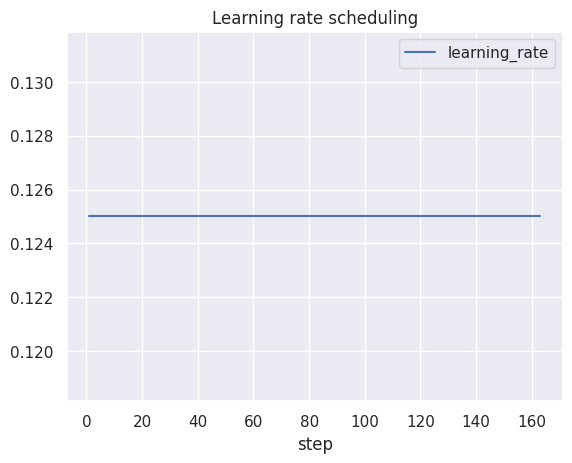

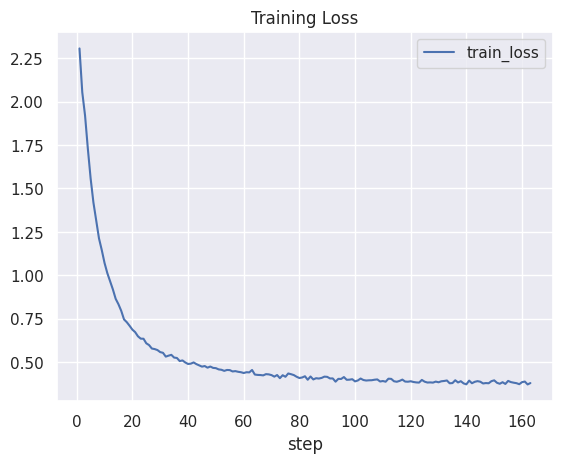

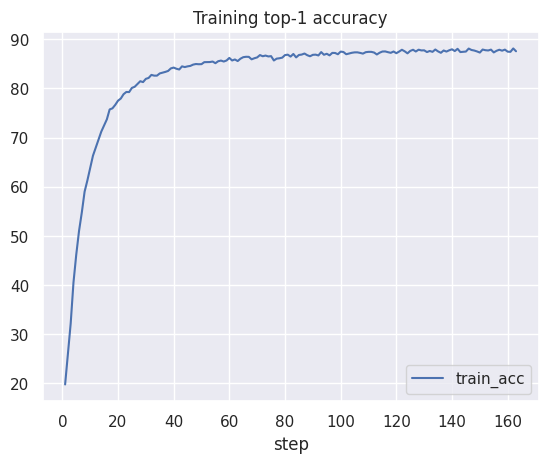

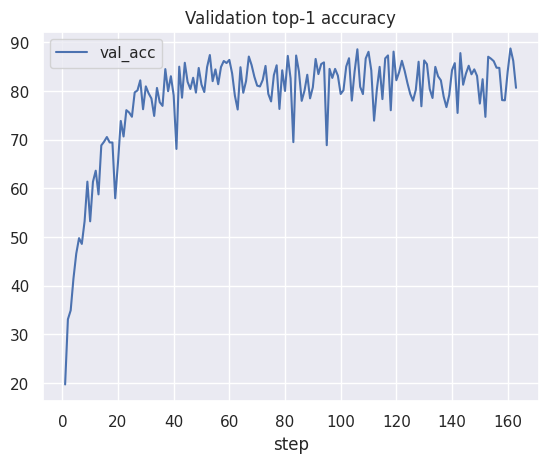

In [34]:
add_tain_to_supCE_run(path_run_md, path_out)